In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(gammapy)

loaded gammapy version: 0.1.dev19174+g56b5bdf 
<module 'gammapy' from '/home/wecapstor1/caph/mppi045h/gammapy/gammapy/__init__.py'>


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../../../')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

In [5]:
figformat = '[png]'

In [6]:
scale  = 0.025
scaled_amplitude = Parameter('amplitude', 
                             value = 4.11e-11 * scale)
cutoff = 80
lambda_ = Parameter('lambda_', value = 1/ cutoff )
dataset_asimov  = Dataset_load.create_asimov(model = 'ecpl',source = "PKSflare",
                                            parameters = Parameters([scaled_amplitude, lambda_]))


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


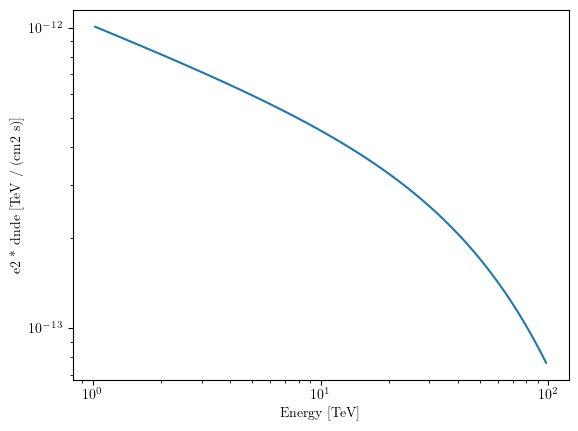

In [7]:
ax =dataset_asimov.models[0].spectral_model.plot([1,100]*u.TeV, energy_power= 2)


In [8]:
biass = [ 0.0]
bias_assumed = 0.1
sigmass = [0]
sigma_assumed = 0.1


In [9]:
def create_dataset(b, s):
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution = s,
                        rnd = False,
                        e_reco_creation=100,
                        cutoff=True)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(100)
    dataset_conv_N.models.parameters['resolution'].frozen  = True
    

    zero = 1e-12
    penalising_invcovmatrix = np.zeros((4,4))
    np.fill_diagonal(penalising_invcovmatrix, [1/bias_assumed**2, 1/sigma_assumed**2, 1/zero**2, 1/zero**2])

    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    dataset_conv_N.irf_model.eff_area_model.parameters.freeze_all()
    dataset_conv_N.irf_model.parameters['resolution'].frozen = False
    dataset_conv_N.irf_model.parameters['norm_nuisance'].frozen = True
    
    return dataset_conv, dataset_conv_N

datasets_conv =[]
datasets_conv_N =[]

for b in biass:
    dataset_conv, dataset_conv_N  = create_dataset(b, sigmass[0])
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    


In [10]:
emask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1)>0
#thr = 1*u.TeV
emask_center= dataset_asimov.geoms['geom'].axes[0].center[emask]
edges_masked = dataset_asimov.geoms['geom'].axes[0].edges[len(emask_center):]

In [11]:
datasets_conv_N[0].e_reco_n 

100

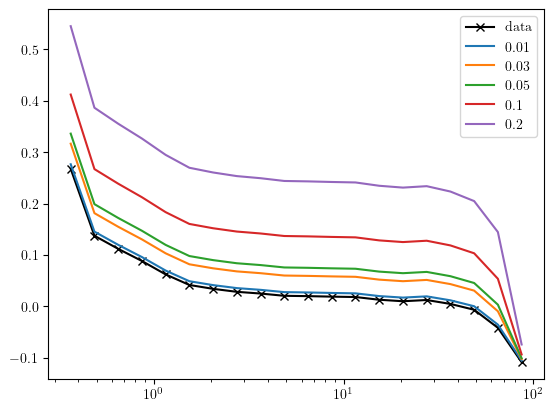

In [12]:
edispKernelMap = datasets_conv_N[0].npred_edisp()
edispKernel = edispKernelMap.get_edisp_kernel()

plt.plot(emask_center, edispKernel.get_bias(emask_center), label = 'data',
        color = 'black', marker = 'x')

values = [0.01, 0.03, 0.05,0.1, 0.2]
for value in values:
    datasets_conv_N[0].models.parameters['bias'].value = value
    edispKernelMap = datasets_conv_N[0].npred_edisp()
    edispKernel = edispKernelMap.get_edisp_kernel()

    plt.plot(emask_center, edispKernel.get_bias(emask_center),
             label = datasets_conv_N[0].models.parameters['bias'].value ,
            )
    plt.xscale("log")
datasets_conv_N[0].models.parameters['bias'].value = 0
    
plt.legend()

In [13]:
print(datasets_conv_N[0].models)

DatasetModels

Component 0: SkyModel

  Name                      : Y1yXTNX-
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.03e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.013   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    no

In [14]:
def sum_e (data):
    return data.sum(axis=2).sum(axis=1)

eaxis_standard = dataset_asimov.geoms['geom'].axes[0]

<WCSAxes: >

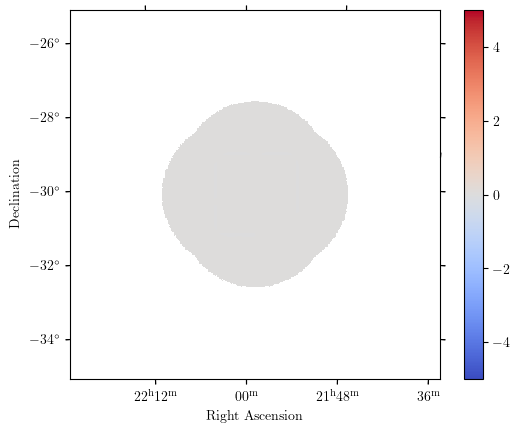

In [15]:
d = dataset_conv_N
d.plot_residuals_spatial()

In [16]:
energy = datasets_conv[0].counts.geom.axes[0].center.value
energy_bounds = (energy[0], energy[-1] ) * u.TeV
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1134: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


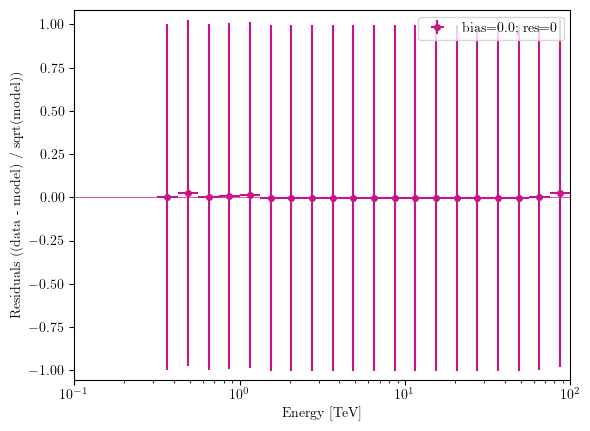

In [17]:
fig, ax = plt.subplots()
i = 0

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}", method = 'diff/sqrt(model)')
        #d = datasets_conv_N_fine[i]
        #d.plot_residuals_spectral(ax =ax, color= colors[1], 
        #            label = f"bias={b}; res={s}")
        i += 1
ax.legend()

fig.savefig(f"plots/2_Residual_pre_fit.png")

In [18]:
npreds_pre_fit = []
npreds_pre_fit_N = []
i =0
biass_extreme = [-0.1, 0., 0.1]
for b in biass_extreme:
    for s in sigmass:
        datasets_conv_N[0].models.parameters['bias'].value = b
        
        npreds_pre_fit.append( sum_e(datasets_conv[0].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[0].npred_signal().data))
        i += 1
datasets_conv_N[0].models.parameters['bias'].value = 0


In [19]:
color_standard = colors[0]; color_standard_e = colors[2] #mediumvioletred
color_nui = colors[1]; color_nui_e = colors[3]
color_input = 'darkorange'
color_rnd = 'darkgreen'


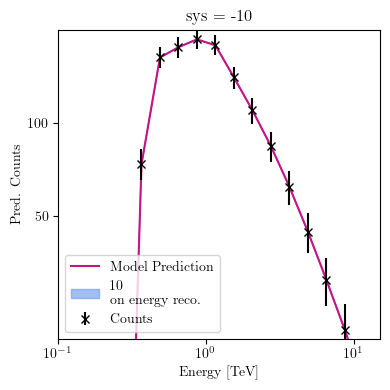

In [20]:

fig,a = plt.subplots(1,1, sharey = True, figsize =  (4,4))

a.plot(energy,npreds_pre_fit[1], label = "Model Prediction", color = color_standard)

a.fill_between(energy, npreds_pre_fit[0], npreds_pre_fit[2],
             color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy reco.")
a.errorbar(energy, sum_e(d.counts.data-d.background.data), 
         yerr = np.sqrt(sum_e(d.counts.data-d.background.data)),
        fmt = 'x', label = "Counts", color = 'black')


a.loglog()
a.legend(loc = 'lower left')
a.set_xlabel("Energy [TeV]")
a.set_ylim(2e1, 2e2)
a.set_yticks([50,100], ['50', '100'])
a.set_xlim(0.1, 15)
a.set_ylabel("Pred. Counts")
a.set_title("sys = -10%"); 

plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"plots/2_Npred_single.png")


corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.167e+05                  │              Nfcn = 172              │
│ EDM = 2.47e-05 (Goal: 0.0002)    │           time = 21.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

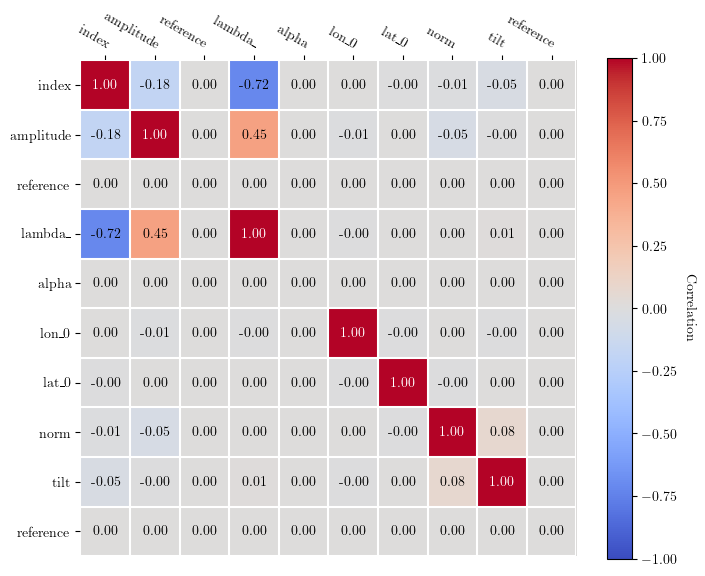

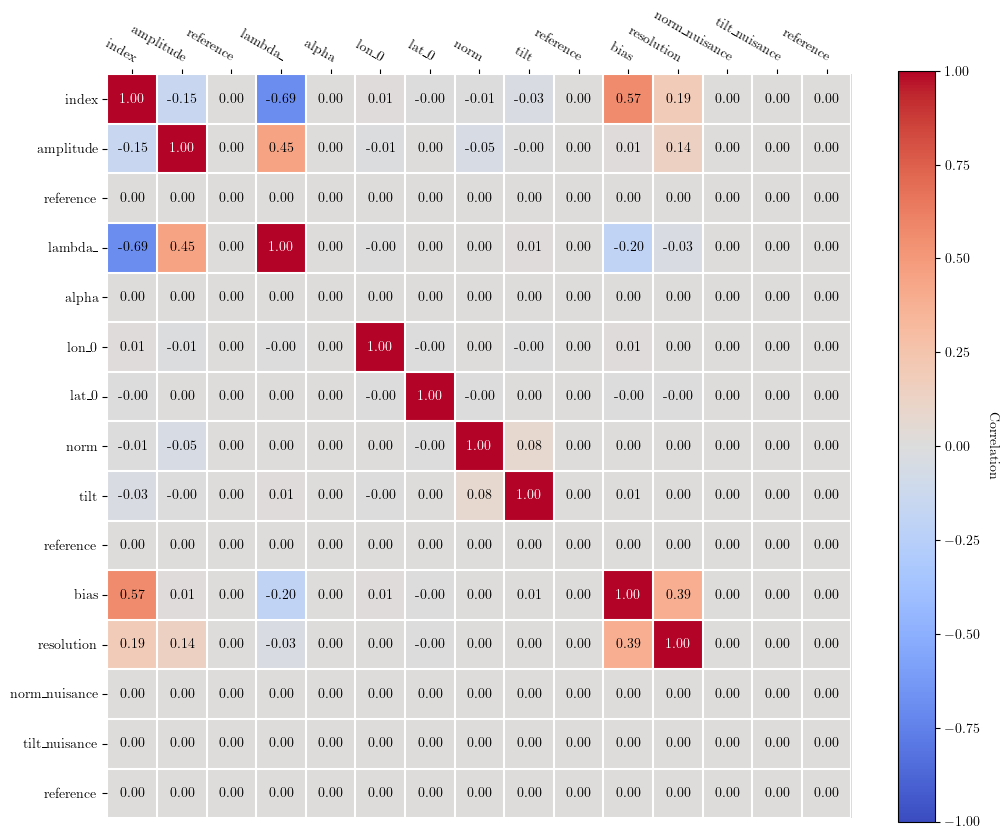

In [21]:
%%time
fitting = 1

if fitting:

    print("corr")
    for d in datasets_conv:
        fit_cor = Fit(store_trace=True)
        result_cor = fit_cor.run(d)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor.minuit)
    print("Nuisance")
    for d in datasets_conv_N:
        fit_cor_N = Fit(store_trace=True)
        result_cor_N = fit_cor_N.run(d)
        d.models.covariance = fit_cor_N.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor_N.minuit)
    
    print("saving")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[i]}_sigma_0.yml'
        d.models.write(path,overwrite=True)
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[i]}_sigma_0.yml'
        d.models.write(path,overwrite=True)
        
else:
    print("read")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_{biass[i]}_sigma_0.yml'
        datasets_conv[i] = Dataset_load.load_dataset_N(d, path)        
    print("read nui")
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_{biass[i]}_sigma_0.yml'
        datasets_conv_N[i] = Dataset_load.load_dataset_N(d, path)        
        
    



In [22]:


import sys
sys.path.append(config['local']['path']+'/nuisance_summary/Eff_area')
import upper_limit_18_02
import yaml

In [23]:
def get_er_neg_pos(parameter, N, case):
    filename = '5_scan_'+parameter
    if N:
        filename += '_N'
    filename += case
    filename += '.yaml'
    print(filename)
    with open('data/'+filename) as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
        
    ll_N_a = stat_profile_N_a.copy()
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)    
    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    return er_neg, er_pos

In [24]:
valuies_asimov_N = []
valuies_asimov = []
cases = ['-10', '', '+10']
par_names = ['amplitude', 'index', 'lambda_']
for i in range(len(datasets_conv)):
    print(i)
    valuies_asimov_Ns = []
    valuies_asimovs = []

    for par in par_names:
        
        try:
            er_neg, er_pos = get_er_neg_pos(par, True, cases[i])
            valuies_asimov_Ns.append([datasets_conv_N[i].models.parameters[par].error, er_neg, er_pos])
        
            er_neg, er_pos = get_er_neg_pos(par, False, cases[i])
            valuies_asimovs.append([datasets_conv[i].models.parameters[par].error, er_neg, er_pos])
        except:
            valuies_asimov_Ns.append(3*[datasets_conv_N[i].models.parameters[par].error])
            valuies_asimovs.append(3*[datasets_conv[i].models.parameters[par].error])
            print('not found ', par, 'dataset:', i)
            
    valuies_asimov_N.append(valuies_asimov_Ns)
    valuies_asimov.append(valuies_asimovs)

print(valuies_asimov_N)
print(valuies_asimov)



0
5_scan_amplitude_N-10.yaml
not found  amplitude dataset: 0
5_scan_index_N-10.yaml
not found  index dataset: 0
5_scan_lambda__N-10.yaml
not found  lambda_ dataset: 0
[[[3.832012735676759e-14, 3.832012735676759e-14, 3.832012735676759e-14], [0.06350659569169585, 0.06350659569169585, 0.06350659569169585], [0.011623118553573146, 0.011623118553573146, 0.011623118553573146]]]
[[[3.7877248826420556e-14, 3.7877248826420556e-14, 3.7877248826420556e-14], [0.05208972874482144, 0.05208972874482144, 0.05208972874482144], [0.011350335307889188, 0.011350335307889188, 0.011350335307889188]]]


In [25]:
energy_fine = np.logspace(np.log10(energy_bounds[0].value),
                         np.log10(energy_bounds[-1].value),
                         100)

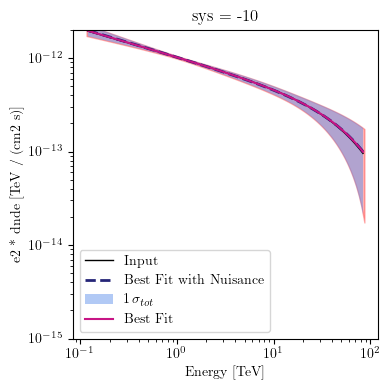

In [26]:


fig,axs = plt.subplots(1,1, sharey=True,figsize = (4,4))
axs = [axs]
for i,ax in enumerate(axs):
    if i ==1:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )
        
for i in range(len(datasets_conv_N)):
    
    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
  
    m = 1
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
    neg = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
    neg = (neg[0] - neg[1]).value
    m = 2
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m]  
    pos = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
    pos = (pos[0] + pos[1]).value
    
    axs[i].fill_between(energy_fine, neg, pos, alpha = 0.3, color = 'red')
    
    m = 0
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_nui_e,
                                                             label="1$\,\sigma_{tot}$",
                                                            alpha = 0.5)
    
    
    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    #dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
    #                                                       facecolor=color_standard_e,
    #                                                          alpha = 0.9,
    #                                                          label= "1$\,\sigma_{stat}$"
    #                                                         )
[a.legend(loc = 'lower left') for a in axs]
[a.set_ylim(1e-15,2e-12) for a in axs]

axs[0].set_title("sys = -10%"); #axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.svg")

In [27]:
color_nui_e

'cornflowerblue'

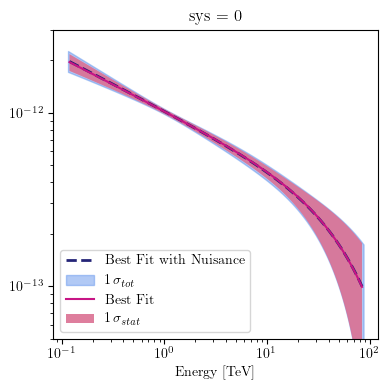

In [28]:


fig,axs = plt.subplots(1,1, sharey=True,figsize = (4,4))
axs = [ axs]


for i in range(len(datasets_conv_N)):

    dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                            label = "Input", color = 'black', linewidth = 2, linestyle="dotted")

    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        

    m = 1
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
    neg = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV,)*energy_fine**2
    neg = (neg[0] - neg[1]).value
    m = 2
    for v, p in enumerate(par_names):
        datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m]  
    pos = datasets_conv_N[i].models[0].spectral_model.evaluate_error(energy_fine*u.TeV, ) *energy_fine**2
    pos = (pos[0] + pos[1]).value

    axs[i].fill_between(energy_fine, neg, pos, alpha = 0.5, color = color_nui_e,
                       label="1$\,\sigma_{tot}$",)

    m = 0
    #for v, p in enumerate(par_names):
    #    datasets_conv_N[i].models.parameters[par].error = valuies_asimov_N[i][v][m] 
    #dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
    #                                                       facecolor=color_nui_e,
    #                                                         label="1$\,\sigma_{tot}$",
    #                                                        alpha = 0.5)


    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_standard_e,
                                                              alpha = 0.9,
                                                              label= "1$\,\sigma_{stat}$"
                                                             )
axs[0].legend(loc='lower left')
axs[0].set_title("sys = 0%"); 
axs[0].set_ylim(5e-14,3e-12) 
axs[0].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison_single.png")

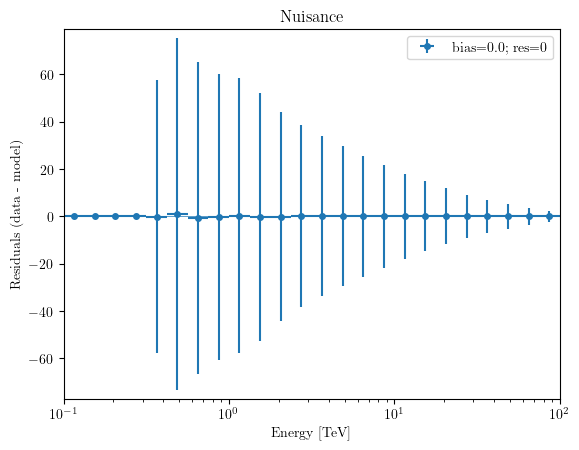

In [29]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv_N[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Nuisance")

fig.savefig(f"plots/2_Residual_post_fit.svg")

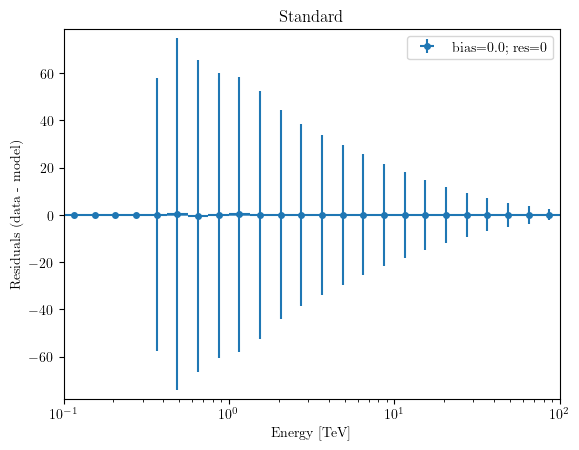

In [30]:
fig, ax = plt.subplots()
i = 0
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for b in biass:
    for s in sigmass:
        d = datasets_conv[i]
        d.plot_residuals_spectral(ax =ax, color= colors[i], 
                    label = f"bias={b}; res={s}")
        i += 1
ax.legend()
plt.title("Standard")
fig.savefig(f"plots/2_Residual_post_fit_standard.svg")

84.38943792760821


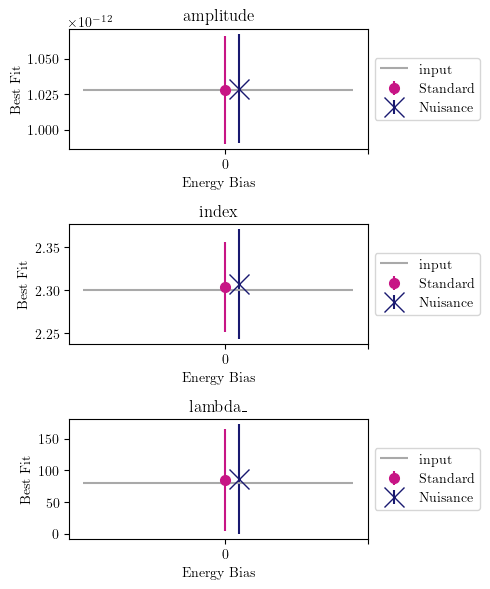

In [31]:
fig, axs = plt.subplots(3,1, figsize= (5, 6))
ax = axs.flatten()


parnames = ['amplitude', 'index', 'lambda_']
ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            if p =='lambda_':
                l_value = d.models.parameters[p].value
                l_error = d.models.parameters[p].error 
                value = 1/ l_value  # c
                print(value)
                error = l_error / (l_value **2 )
            else:
                value = d.models.parameters[p].value
                error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_standard,markersize = 7,
                          label = f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            if p =='lambda_':
                l_value = d.models.parameters[p].value
                l_error = d.models.parameters[p].error 
                value = 1/ l_value  # c
                error = l_error / (l_value **2 )
            else:
                value = d.models.parameters[p].value
                error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.1), value, yerr = error,
                           fmt = 'x', color = color_nui,markersize=14,
                          label ="Nuisance")
            #ax[i].errorbar((ii+0.3), value, yerr = error, fmt = '.', color = color_nui,markersize=14,
            #              label ="Nuisance")
            
        ii +=1
labels_sys = [ '0%', '']
for i, p in enumerate(parnames):
    value = dataset_asimov.models.parameters[p].value
    if p == 'lambda_':
        value = 1/value
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, -1, 0.9, label = "input", color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
    
plt.tight_layout()
fig.savefig(f"plots/2_Best_fit_parameters.svg")
    

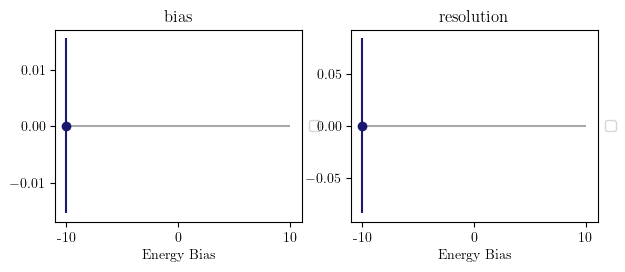

In [32]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_nui)
            ax[i].set_title(p)
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
labels_sys = [ '-10%', '0%', '10%']
for i, p in enumerate(parnames):
    value = 0
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1,  color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
fig.savefig(f"plots/2_Best_fit_nui_parameters.svg")
    